# Phase 3: Modeling part 1

In [402]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
sns.set(font_scale=1.5)

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from scipy.interpolate import spline

pd.options.mode.chained_assignment = None 

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [403]:
# Read the data and features from the pickle
#df, discrete_features, continuous_features, ret_cols = pickle.load(open( "C:\Anaconda\semester1\p2p\clean_data.pickle", "rb" ))

In [404]:
#Loading from pickle file 
df, float_cols, cat_cols, perc_cols, date_cols = \
                            pickle.load(open("C:\Anaconda\semester1\p2p\p2p_eda_2_data.pickle", "rb" ))

In [406]:
for col in cat_cols:
    print(col, df[col].nunique())

term 2
grade 7
sub_grade 35
emp_length 11
home_ownership 5
verification_status 3
loan_status 3
purpose 13
pymnt_plan 1
zip_code 909
addr_state 50
initial_list_status 2
application_type 2
hardship_flag 1
disbursement_method 2
debt_settlement_flag 2


In [407]:
df.shape

(468764, 65)

In [408]:
df.drop(['zip_code', 'sub_grade', 'loan_status'], axis = 1, inplace = True)

In [409]:
cat_cols

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'loan_status',
 'purpose',
 'pymnt_plan',
 'zip_code',
 'addr_state',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

In [410]:
cat_cols.remove('zip_code')
cat_cols.remove('loan_status')
cat_cols.remove('sub_grade')

In [413]:
cat_cols

['term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'pymnt_plan',
 'addr_state',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

In [414]:
cat_cols.remove('debt_settlement_flag')

In [415]:
continuous_features = float_cols + perc_cols
discrete_features = cat_cols

In [416]:
continuous_features

['loan_amnt',
 'installment',
 'annual_inc',
 'dti',
 'revol_bal',
 'delinq_2yrs',
 'open_acc',
 'inq_last_6mths',
 'pub_rec',
 'total_acc',
 'out_prncp',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'inq_fi',
 'inq_last_12m',
 'acc_open_past_24mths',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pub_rec_bankruptcies',
 'tax_liens',
 'total_bc_limit',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'int_rate',
 'annual_inc_log',
 'int_rate']

In [417]:
continuous_features = [i for i in continuous_features if i not in ['out_prncp', 'tot_coll_amt', 'annual_inc_log']]

In [418]:
# Create a feature for the length of a person's credit history at the
# time the loan is issued
df['cr_hist'] = (df.issue_d - df.earliest_cr_line)/np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [419]:
# Randomly assign each row to a training and test set. We do this now
# because we will be fitting a variety of models on various time periods,
# and we would like every period to use the *same* training/test split
np.random.seed(41)
df['train'] = np.random.choice([True, False], size = len(df), p = [0.8, 0.2])

In [420]:
# Create a matrix of features and outcomes, with dummies. Record the
# names of the dummies for later use
X_continuous = df[continuous_features].values

X_discrete = pd.get_dummies(df[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate((X_continuous, X_discrete), axis = 1 )
y = df.loan_outcome.values
train = df.train.values

In [421]:
data = df.copy()

In [422]:
data.issue_d.max()

Timestamp('2018-06-01 00:00:00')

In [423]:
data.loan_outcome.value_counts()

0    364518
1    104246
Name: loan_outcome, dtype: int64

In [424]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 80000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = 41):
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [470]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = 41,
                          output_to_file = True,
                          print_to_screen = True):
        
    np.random.seed(random_state)
    
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  

    cv_model = GridSearchCV(model, cv_parameters, scoring = 'f1_macro')
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
  
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = False
    except:
        probs_predicted = False
    
   
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
 
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted == False:        
            plt.figure(figsize = (14, 10))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    if probs_predicted == False:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)


    model_preds = {'model':best_model, 'y_pred_labels':y_pred}

    if probs_predicted == False and output_to_file:
        model_preds.update({'y_pred_probs':y_pred_probs})
        print(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs))

    else:
        y_pred_score = best_model.decision_function(X_test)
        model_preds.update({'y_pred_score':y_pred_score})


    return model_preds

## Using only Grade

  Model: Grade only logistic l2
Fit time: 0.64 seconds
Optimal parameters:
{}

Accuracy:  0.7748
             precision    recall  f1-score   support

 No default     0.7831    0.9809    0.8709     15491
    Default     0.5042    0.0668    0.1179      4509

avg / total     0.7202    0.7748    0.7012     20000



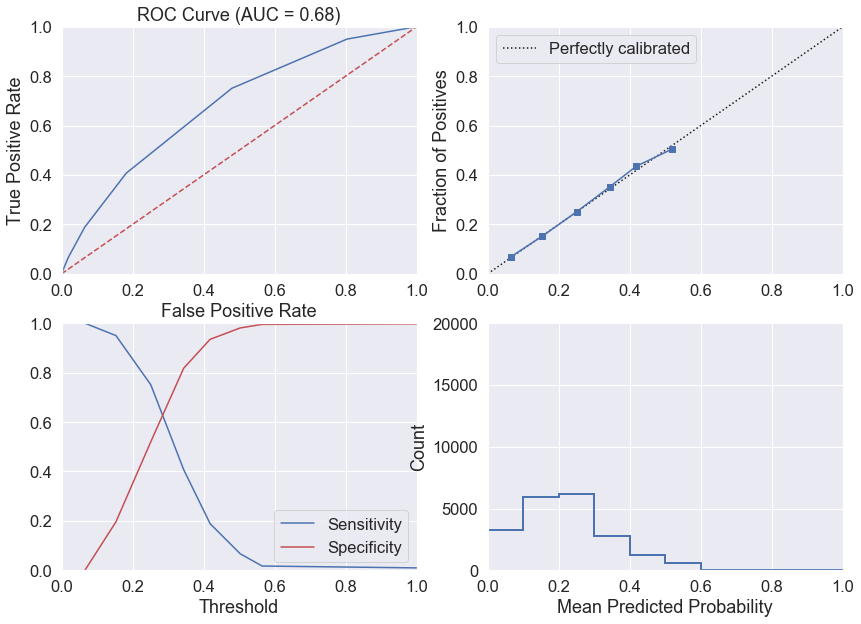

Grade only logistic l2::roc_auc 0.6805490862356796


In [426]:
data_dict = prepare_data(feature_subset=['grade'])
grade_only_logistic = LogisticRegression(penalty = 'l2', C=np.inf, solver='lbfgs')

grade_only_logistic = fit_classification(grade_only_logistic,data_dict,
                                         model_name = 'Grade only logistic l2')

## Using only Interest Rate

  Model: Interest rate only logistics l2
Fit time: 0.24 seconds
Optimal parameters:
{}

Accuracy:  0.7736
             precision    recall  f1-score   support

 No default     0.7862    0.9721    0.8693     15491
    Default     0.4888    0.0916    0.1543      4509

avg / total     0.7191    0.7736    0.7081     20000



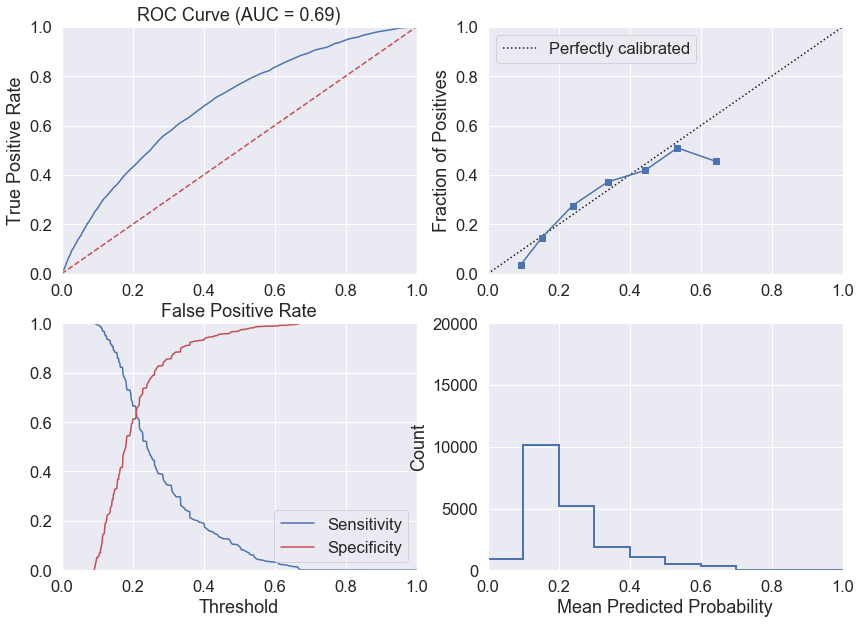

Interest rate only logistics l2::roc_auc 0.6894263675004048


In [427]:
data_dict = prepare_data(feature_subset=['int_rate'])
interest_only_logistic = LogisticRegression(penalty = 'l2', C=np.inf, solver='lbfgs')

interest_only_logistic = fit_classification(interest_only_logistic, data_dict, 
                                   model_name = 'Interest rate only logistics l2')

## Removing Grade, Interest Rate and Installment

In [428]:
final_features = [i for i in discrete_features + continuous_features if i not in ["grade", "int_rate", "installment"]]

data_dict = prepare_data(feature_subset = final_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

  Model: Gaussian Naive Bayes
Fit time: 3.46 seconds
Optimal parameters:
{}

Accuracy:  0.33685
             precision    recall  f1-score   support

 No default     0.8481    0.1752    0.2904     15491
    Default     0.2395    0.8922    0.3776      4509

avg / total     0.7109    0.3368    0.3101     20000



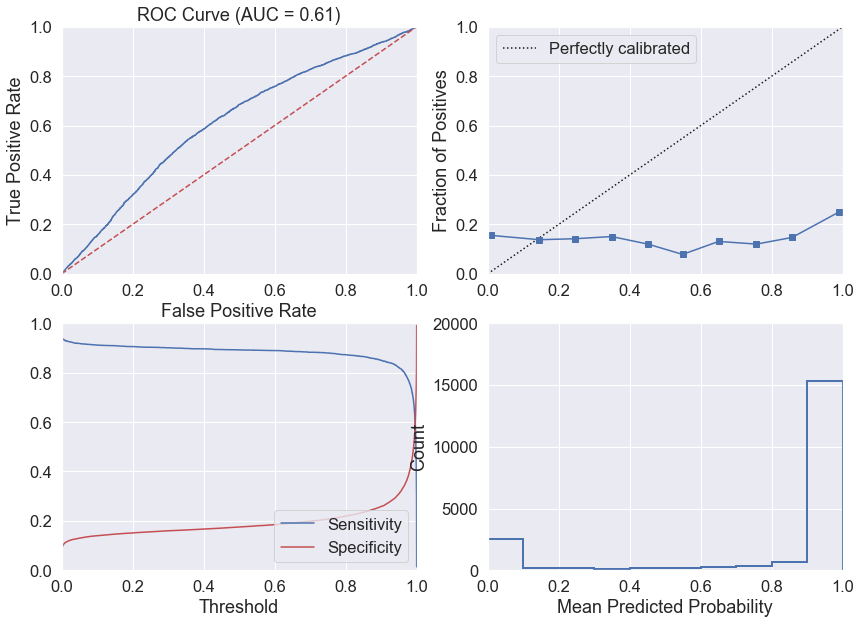

Gaussian Naive Bayes::roc_auc 0.612390042858072


In [473]:
gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, model_name = "Gaussian Naive Bayes")

  Model: base logistic l2
Fit time: 15.83 seconds
Optimal parameters:
{}

Accuracy:  0.7777
             precision    recall  f1-score   support

 No default     0.7870    0.9775    0.8720     15491
    Default     0.5414    0.0914    0.1564      4509

avg / total     0.7317    0.7777    0.7106     20000



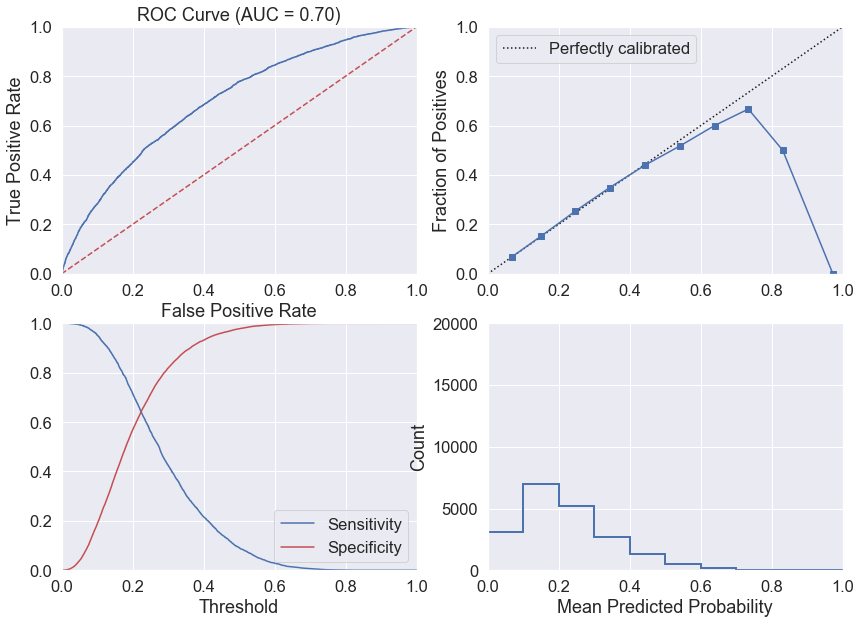

base logistic l2::roc_auc 0.6982295316553144


In [472]:
base_logistic = LogisticRegression(penalty = 'l2', C=np.inf, solver='lbfgs')
base_logistic = fit_classification(base_logistic, data_dict, model_name = 'base logistic l2')

In [431]:
## $l_1$ penalized logistic regression

  Model: l1 Penalized Logistic Regression
Fit time: 202.01 seconds
Optimal parameters:
{'C': 10000000000.0}

Accuracy:  0.7771
             precision    recall  f1-score   support

 No default     0.7871    0.9762    0.8715     15491
    Default     0.5324    0.0929    0.1582      4509

avg / total     0.7297    0.7771    0.7107     20000



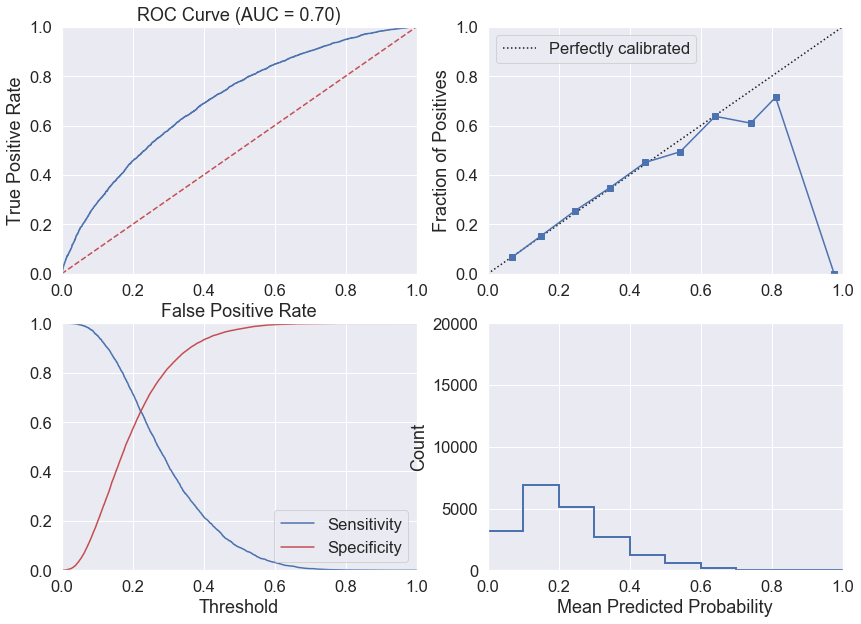

l1 Penalized Logistic Regression::roc_auc 0.7002731710135701


In [432]:
l1_logistic = LogisticRegression(penalty = 'l1')
cv_parameters = {"C":np.logspace(1, 10, num = 2)}
l1_logistic = fit_classification(l1_logistic, data_dict,\
                        cv_parameters = cv_parameters, model_name = "l1 Penalized Logistic Regression")

In [433]:
cv_parameters = {"C":np.logspace(-5, 5, num = 5)}

In [434]:
cv_parameters

{'C': array([1.00000000e-05, 3.16227766e-03, 1.00000000e+00, 3.16227766e+02,
        1.00000000e+05])}

  Model: l2 Penalized Logistic Regression
Fit time: 60.88 seconds
Optimal parameters:
{'C': 100000.0}

Accuracy:  0.77725
             precision    recall  f1-score   support

 No default     0.7872    0.9763    0.8716     15491
    Default     0.5343    0.0934    0.1590      4509

avg / total     0.7302    0.7772    0.7110     20000



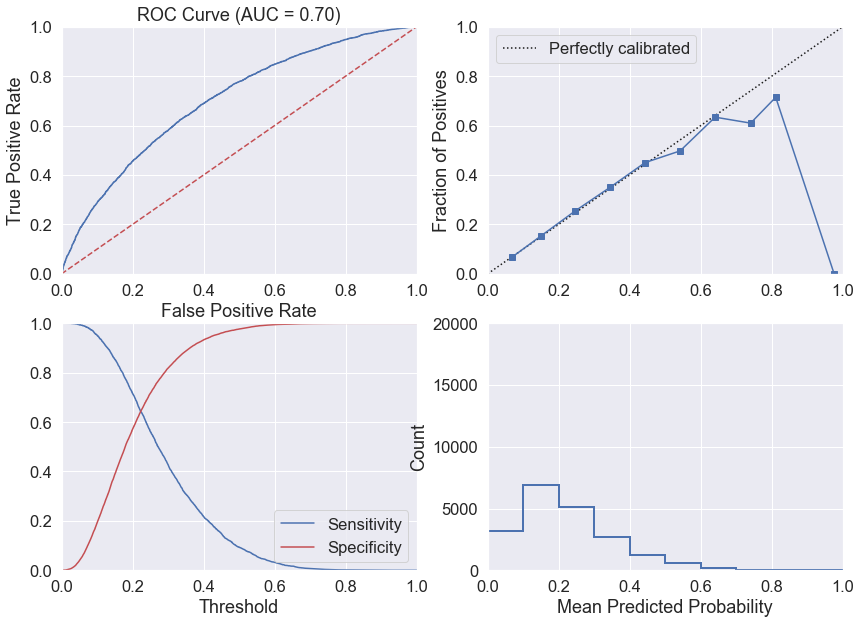

l2 Penalized Logistic Regression::roc_auc 0.7002491191023299


In [435]:
l2_logistic = LogisticRegression(penalty = 'l2')
cv_parameters = {"C":np.logspace(-5, 5, num = 5)}

l2_logistic = fit_classification(l2_logistic, data_dict,\
                        cv_parameters = cv_parameters, model_name = "l2 Penalized Logistic Regression")

In [436]:
l2_logistic['model'].intercept_

array([-1.41314727])

In [437]:
all_features.values

array(['loan_amnt', 'installment', 'annual_inc', 'dti', 'revol_bal',
       'delinq_2yrs', 'open_acc', 'inq_last_6mths', 'pub_rec',
       'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'inq_fi', 'inq_last_12m', 'acc_open_past_24mths', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pub_rec_bankruptcies', 'tax_liens', 'total_bc_limit',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'int_rate', 'int_rate',
       'cr_hist', 'term:: 60 months', 'term::nan', 'grade::B', 'grade::C',
       'grade::D', 'grade::E', 'grade::F', 'grade::G', 'grade::nan',
       'emp_length::10+ years', 'emp_length::2 ye

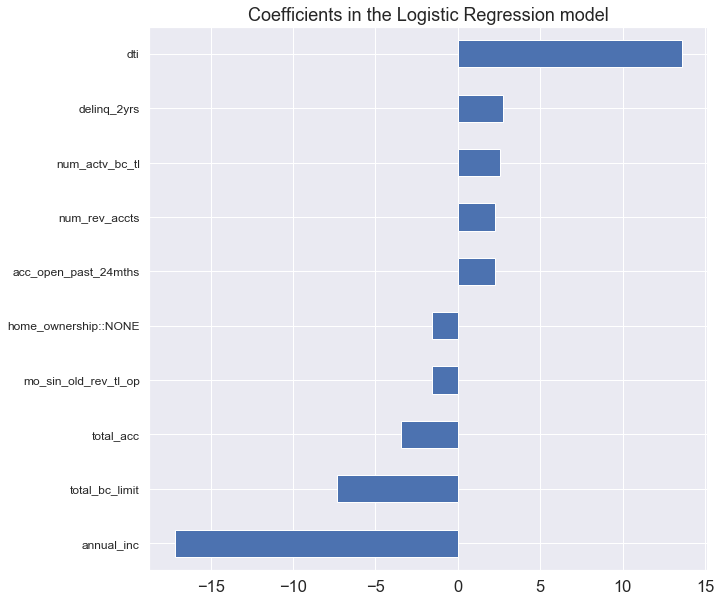

In [438]:
all_features = selected_features.values
plt.figure(figsize=(10,10))
## plotting features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:5]) + list(np.argsort(l2_logistic['model'].coef_)[0,-5:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
yticks = all_features[top_and_bottom_idx]

p1 = bplot.plot(kind='barh', ylim=(-5,10))
p1.set_yticklabels(yticks, size = 12)
plt.title('Coefficients in the Logistic Regression model')
plt.show()

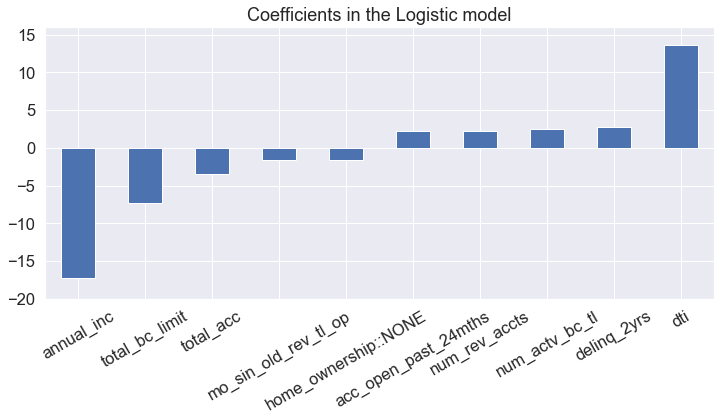

In [447]:
## Plot top 6 most significant features
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:5]) + list(np.argsort(l2_logistic['model'].coef_)[0,-5:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
plt.figure(figsize = (12,5))
p1 = bplot.plot(kind='bar',rot=30,ylim=(-20,16))
plt.title('Coefficients in the Logistic model')
p1.set_xticklabels(xticks)
plt.show()

In [292]:
#Coefficients in logisitc model values
l = []
for i in zip(list(selected_features.values), list(l2_logistic['model'].coef_[0])):
    l.append(i)
coef_df = pd.DataFrame(l).rename(columns={0:'features', 1:'coef'})
coef_df.head(10)

,features,coef
0,loan_amnt,226.718741
1,funded_amnt,226.718741
2,funded_amnt_inv,225.436134
3,annual_inc,-18.880848
4,dti,3.213735
5,revol_bal,-16.238711
6,delinq_2yrs,-20.129641
7,open_acc,-2.141649
8,total_pymnt,-204.839880
9,recoveries,36.866446


## Decision Tree

  Model: Decision tree
Fit time: 21.37 seconds
Optimal parameters:
{'min_samples_leaf': 1000}

Accuracy:  0.77565
             precision    recall  f1-score   support

 No default     0.7785    0.9929    0.8727     15491
    Default     0.5455    0.0293    0.0556      4509

avg / total     0.7259    0.7756    0.6885     20000



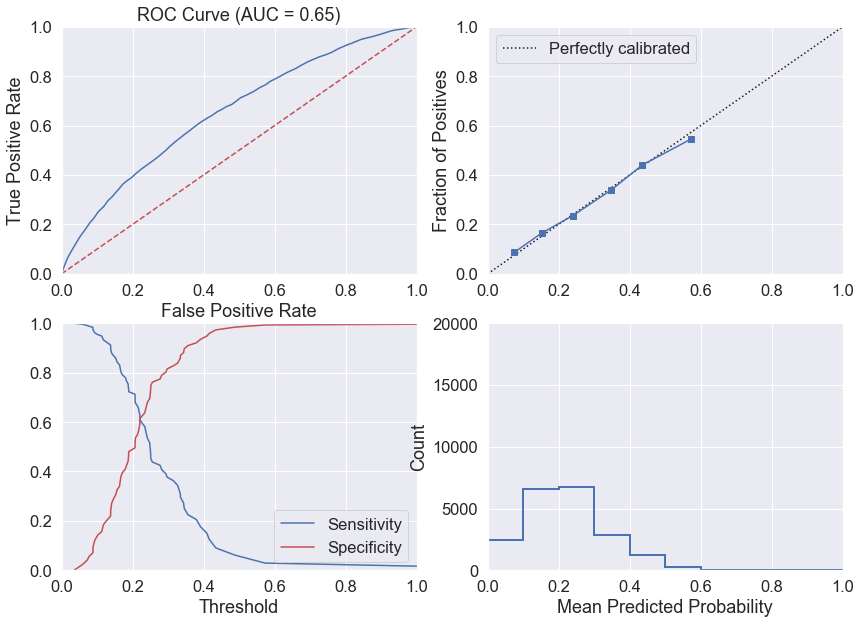

Decision tree::roc_auc 0.6544104211548356


In [474]:
decision_tree = DecisionTreeClassifier()
cv_parameters = {'min_samples_leaf':[500,800, 1000,1300]}
decision_tree = fit_classification(decision_tree, data_dict, 
                          cv_parameters = cv_parameters, model_name = "Decision tree")

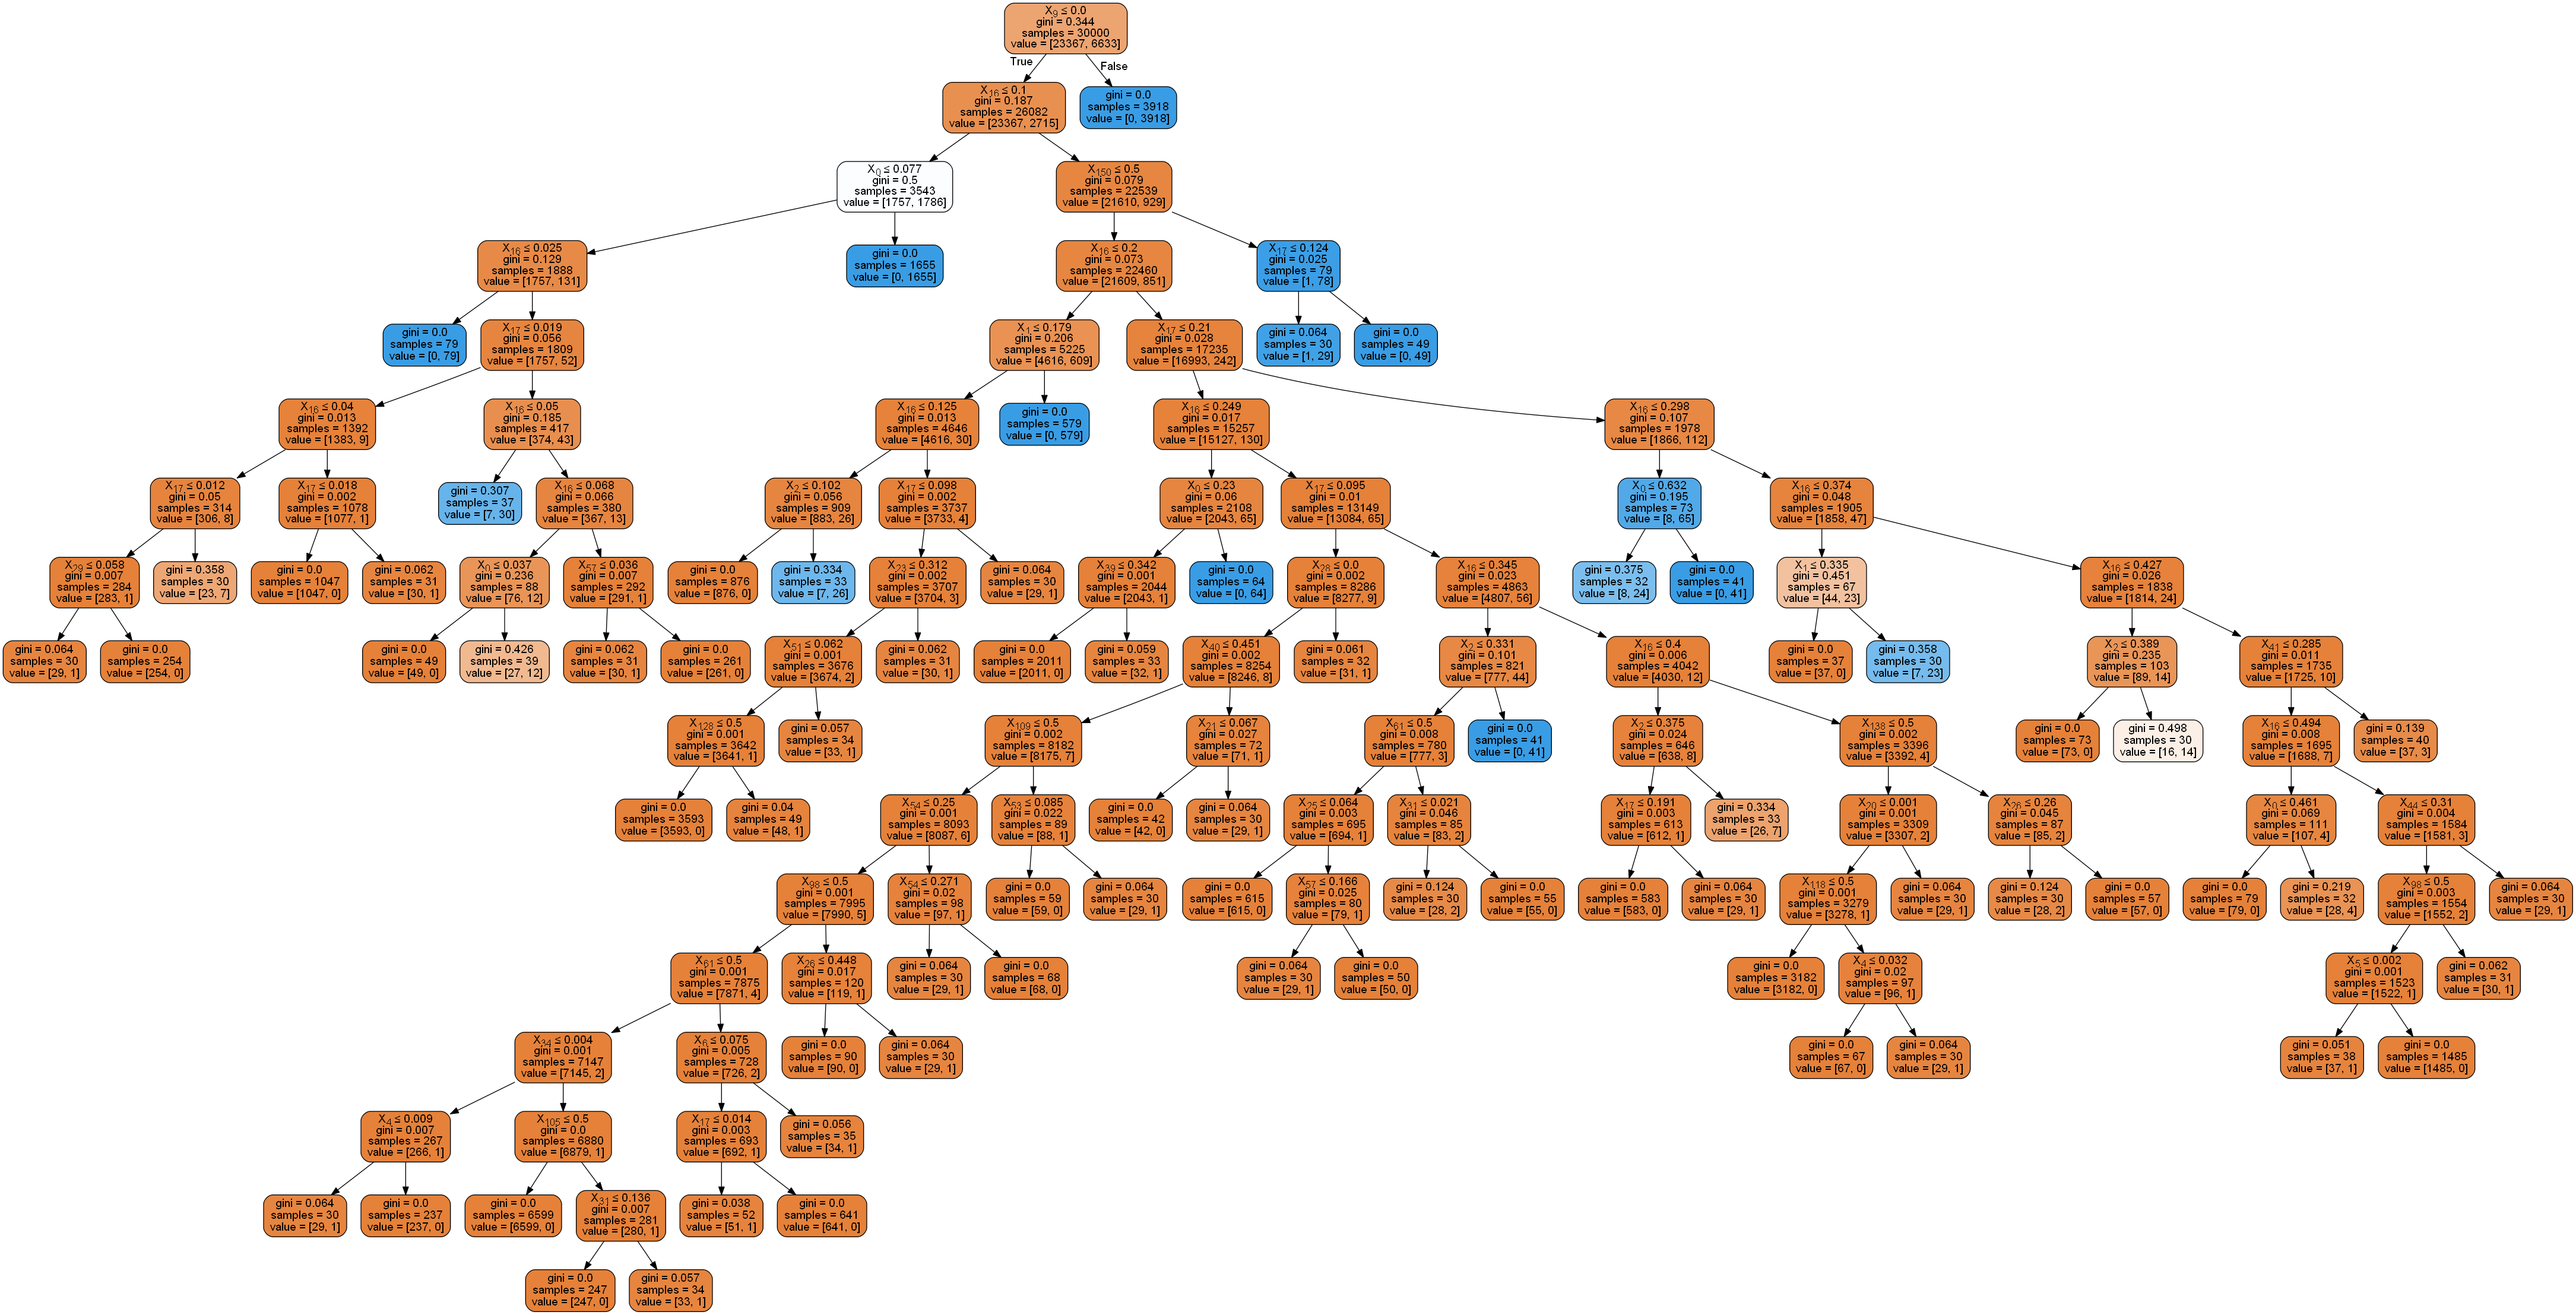

In [294]:
# Visualize the decision tree
# Zooming-in is allowed by double click

dot_data = StringIO()
export_graphviz(decision_tree['model'], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

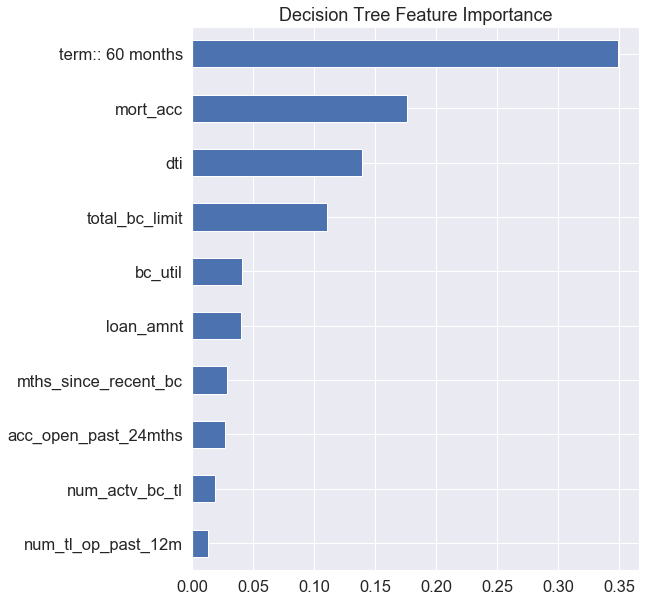

In [450]:
plt.figure(figsize = (8,10))
top_idx = list(np.argsort(decision_tree['model'].feature_importances_)[-10:]) 
bplot = pd.Series(decision_tree['model'].feature_importances_[top_idx])
yticks = all_features[top_idx]

p2 = bplot.plot(kind='barh',ylim=(0,0.2))
p2.set_yticklabels(yticks)
plt.title('Decision Tree Feature Importance');

## Random Forest 

  Model: Random forest
Fit time: 619.97 seconds
Optimal parameters:
{'min_samples_leaf': 20, 'n_estimators': 150}

Accuracy:  0.7025
             precision    recall  f1-score   support

 No default     0.8377    0.7639    0.7991     15491
    Default     0.3773    0.4915    0.4269      4509

avg / total     0.7339    0.7025    0.7152     20000



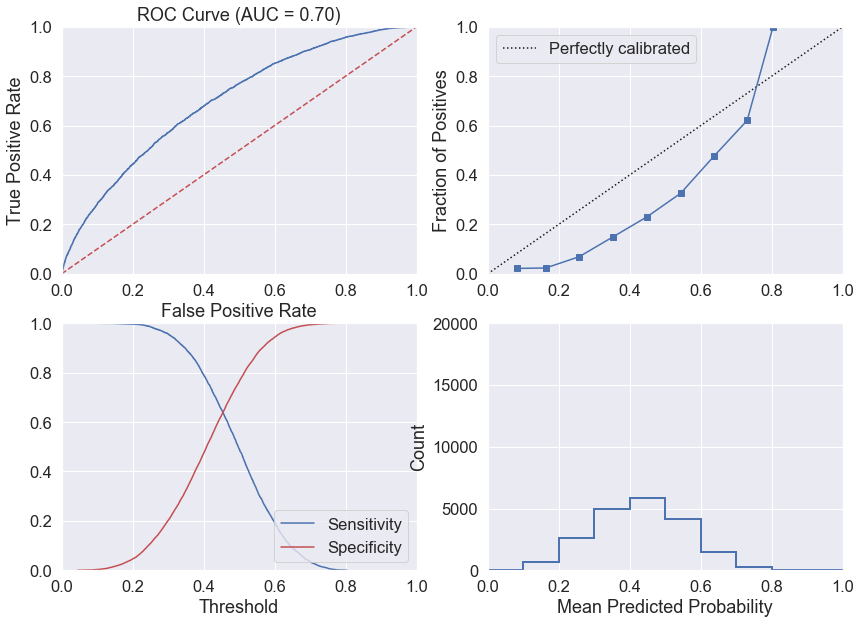

Random forest::roc_auc 0.6985310538592586


In [451]:
random_forest = RandomForestClassifier(class_weight = 'balanced')
cv_parameters = {'min_samples_leaf':[1,5,10,20],'n_estimators': [35, 100, 150]}

random_forest = fit_classification(random_forest, data_dict, cv_parameters=cv_parameters, model_name="Random forest")

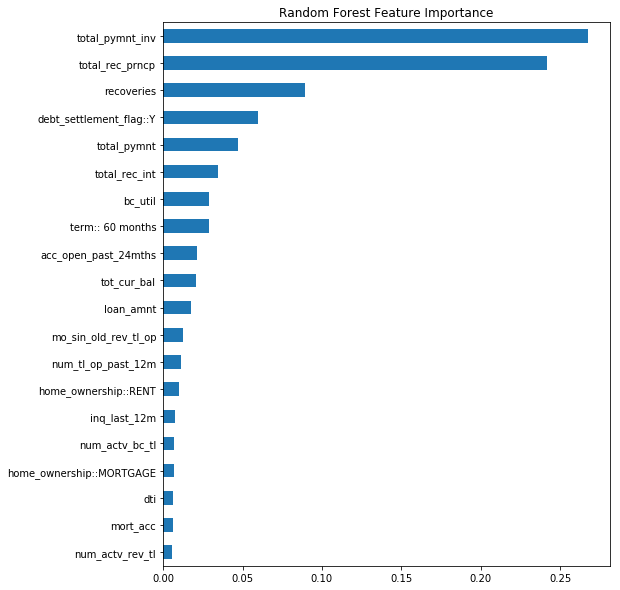

In [297]:
plt.figure(figsize = (8,10))
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-20:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
yticks = selected_features[top_idx]

p2 = bplot.plot(kind='barh',ylim=(0,0.2))
p2.set_yticklabels(yticks)
plt.title('Random Forest Feature Importance');

In [298]:
test_sizes = np.array([25 * 2**k for k in range(10)])
num_rows = len(test_sizes)
T = 10
df_learning_logistic = pd.DataFrame(data=np.zeros((num_rows,T)),columns=list(range(T)))
df_learning_rf = pd.DataFrame(data=np.zeros((num_rows,T)),columns=list(range(T)))

df_learning_logistic.index = test_sizes
df_learning_rf.index = test_sizes

In [299]:
def fit_classification2(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = 41,
                          output_to_file = True,
                          print_to_screen = True):
  
    np.random.seed(random_state)
    
   
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
   
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            plt.show()
        
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
 
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
 
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
   
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

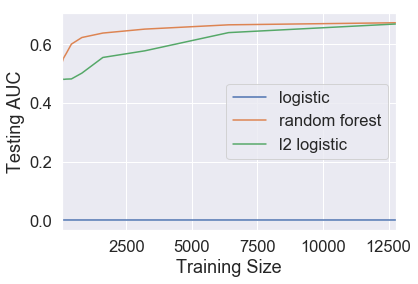

In [468]:
test_sizes = np.array([25 * 2**k for k in range(10)])
num_rows = len(test_sizes)
T = 10
df_learning_logistic = pd.DataFrame(data=np.zeros((num_rows,T)),columns=list(range(T)))
df_learning_rf = pd.DataFrame(data=np.zeros((num_rows,T)),columns=list(range(T)))

df_learning_logistic.index = test_sizes
df_learning_rf.index = test_sizes

for t in range(T):
    
    data_dict_t = prepare_data(n_samples_train=10000,n_samples_test=10000,
                                   feature_subset=final_features, random_state=t)
    X_test_t = data_dict_t['X_test']
    y_test_t = data_dict_t['y_test']
    
    for size in test_sizes:
        
        # get training data based on the specified size
        data_dict_t = prepare_data(n_samples_train=int(size),n_samples_test=10000,
                                   feature_subset=final_features, random_state=t)
        
        l2_logistic_t = LogisticRegression(penalty = 'l2')
        cv_parameters = {"C":np.logspace(-4, 4, num = 4)}

        l2_logistic_t = fit_classification2(l2_logistic_t, data_dict_t,
                            cv_parameters = cv_parameters, model_name = "l2 Penalized Logistic Regression",
                                      print_to_screen = False, output_to_file = False)

        random_forest_t = RandomForestClassifier()
        cv_parameters = {'min_samples_leaf':[1,5,10], 'n_estimators': [35,100] }

        random_forest_t = fit_classification2(random_forest_t, data_dict_t,
                                       cv_parameters=cv_parameters, model_name="Random forest",
                                             print_to_screen = False, output_to_file = False)

        df_learning_logistic.loc[size,t] = roc_auc_score(y_test_t, l2_logistic_t['model'].predict_proba(X_test_t)[:,1])
        df_learning_rf.loc[size,t] = roc_auc_score(y_test_t, random_forest_t['model'].predict_proba(X_test_t)[:,1])


df_learning = pd.DataFrame(data=np.zeros((num_rows,2)),columns=['logistic', 'random forest'])
df_learning.index = test_sizes
df_learning.loc[:,'l2 logistic'] = np.mean(df_learning_logistic.iloc[:,:11],axis=1)
df_learning.loc[:,'random forest'] = np.mean(df_learning_rf.iloc[:,:11], axis=1)
df_learning.plot()
plt.ylabel('Testing AUC')
plt.xlabel('Training Size')
plt.show()

In [301]:
test_sizes = np.array([25 * 2**k for k in range(15)])
test_sizes

## Time Stability Test

In [303]:
#Train and test on the first one year 

In [304]:
np.sum(data.issue_d < datetime.date(2016,12,31))

274224

  Model: Random forest
Fit time: 576.2 seconds
Optimal parameters:
{'min_samples_leaf': 1, 'n_estimators': 35}

Accuracy:  0.7713
             precision    recall  f1-score   support

 No default     0.7798    0.9806    0.8687     15437
    Default     0.4907    0.0633    0.1122      4563

avg / total     0.7138    0.7713    0.6961     20000



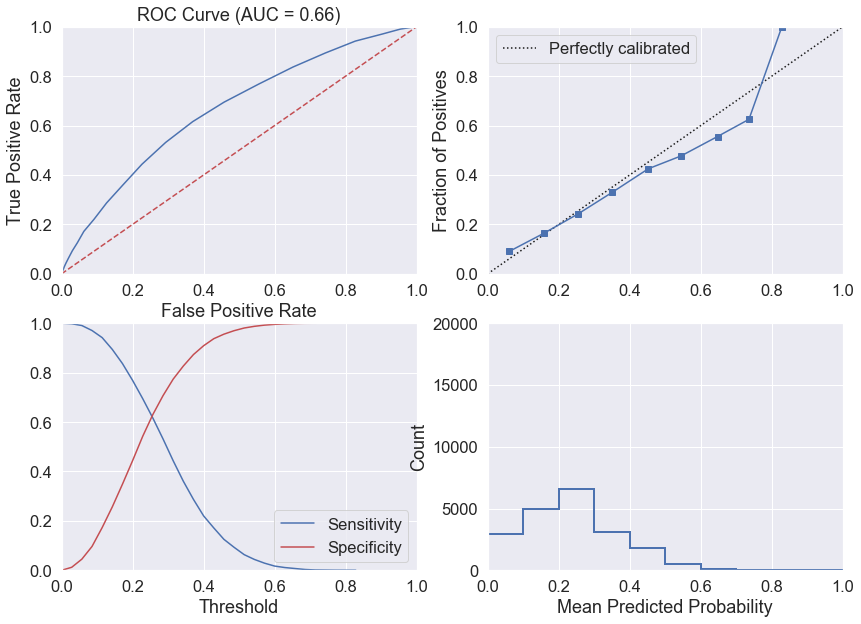

Random forest::roc_auc 0.6641665612918497


{'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'y_pred_labels': array([0, 0, 0, ..., 0, 1, 0], dtype=int64),
 'y_pred_probs': array([0.11428571, 0.31428571, 0.22857143, ..., 0.28571429, 0.54285714,
        0.17142857])}

In [477]:
start_date = datetime.date(2016,1,1)
end_date = datetime.date(2016,12,31)

data_dict_test = prepare_data(date_range_train = (start_date, end_date), date_range_test = (start_date, end_date),
                         n_samples_train = 80000, n_samples_test = 20000, feature_subset = final_features)

cv_parameters = {'min_samples_leaf':[1,5,10,20],'n_estimators': [35, 100, 150]}

fit_classification(RandomForestClassifier(), data_dict_test,
                   cv_parameters = cv_parameters, model_name = "Random forest")

In [306]:
#Train on first one year and test on last 6 months 

In [307]:
np.sum(data.issue_d < datetime.date(2016,12,31))

274224

In [478]:
start_date_train = datetime.date(2016,1,1)
end_date_train = datetime.date(2016,12,31)
start_date_test = datetime.date(2018,1,1)
end_date_test = datetime.date(2018,6,1)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 80000, n_samples_test = 20000, feature_subset = final_features)

  Model: Random forest
Fit time: 579.14 seconds
Optimal parameters:
{'min_samples_leaf': 1, 'n_estimators': 35}

Accuracy:  0.8035110533159948
             precision    recall  f1-score   support

 No default     0.8173    0.9758    0.8895      6234
    Default     0.3887    0.0659    0.1127      1456

avg / total     0.7361    0.8035    0.7424      7690



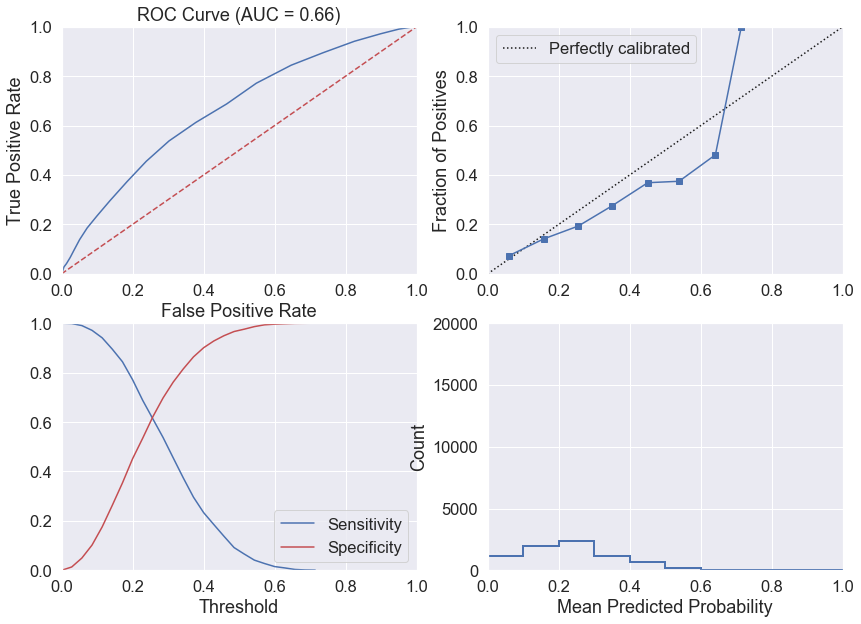

Random forest::roc_auc 0.6629108429667862


{'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'y_pred_labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'y_pred_probs': array([0.17142857, 0.31428571, 0.02857143, ..., 0.31428571, 0.17142857,
        0.14285714])}

In [479]:
cv_parameters = {'min_samples_leaf':[1,5,10,20],'n_estimators': [35, 100, 150]}

fit_classification(RandomForestClassifier(), data_dict_test,
                   cv_parameters = cv_parameters, model_name = "Random forest")